This is updated and organized code, which runs the steepest descent in 0.8s compared to 14s in the previous version. A simulation run of 20000 steps is performed in 6.9s, compared to 690s previously. The simulation runtime also scales with n(steps), which is nice.

In [387]:
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

from numba import njit


import copy
import numpy as np
import scipy as scy

In [395]:


from math import nan

from numpy import float64


class Box():
    """Box-class: defining a rectangular box-shape, in which Particles can roam. One corner is always (0,0)\n
    box         : 2-dimensional array of the two lengths of the x- and y-axis, corresponding to the boundaries of the box.\n
    particles   : a list of all particles in the box\n
    n_particles : the number of particles inside of the box
    """
    def __init__(self, box_size, n_Particles:int):
        """Initializing the Box-class\n
        box_size    : a 2-dimensional array of the two lengths of the x- and y-axis, corresponding to the boundaries of the box.\n
        n_Particles : an integer of the number of Particles in the box. Needed to initialize all arrays correctly
        """
        # constants
        self.c_6        = 6.2647225     # kg/mol  *  nm**8/ns**2
        self.c_12       = 9.847044e-3   # kg/mol  *  nm**14/ns**2
        self.kB         = 1.380e-23     # J/K
        self.avogadro   = 6.022e23      # 1/mol

        self.box_size       = box_size
        # Particles statistics are no longer stored in a separate class but in arrays, which allows for easier calculations
        self.particles_pos  = np.zeros((n_Particles,2))
        self.particles_vel  = np.zeros((n_Particles,2))
        self.particles_acc  = np.zeros((n_Particles,2))

        self.particles_r    = np.zeros(n_Particles)
        self.particles_m    = np.zeros(n_Particles, dtype=float64)
        
        # We use distance matrices for true distances (distances_mat) in x and y coords, 
        # distances with ghost particles for cross boundary calculations (distance_ghost) in x and y coords
        # and the norm of the ghost_distances as a single float
        self.distance_mat   = np.zeros((n_Particles,n_Particles,2))
        self.distance_ghost = np.zeros((n_Particles,n_Particles,2))
        self.distance_abs   = np.zeros((n_Particles,n_Particles))
        # A vectorial force matrix to store the forces between each pair of particles in both directions
        self.force_mat      = np.zeros((n_Particles,n_Particles,2))
        # Storing the energy types currently in the system
        self.potEnergy_mat  = np.zeros((n_Particles,n_Particles,2))
        self.kinEnergy_mat  = np.zeros((n_Particles,n_Particles))

        self.n_particles = n_Particles


    def __repr__(self):
        """printing for debugging"""
        return str("This is a box of size %0.2f by %0.2f" % (self.box_size[0],self.box_size[1]) + ", with %0.2f" % (self.n_particles) + " particles")

    def random_positions(self, axis, n_particles = 0) -> None:
        """return random positions for a number of particles (only one axis)\n
        axis        : either 0 or 1.     0 = x-axis, 1 = y-axis\n
        n_particles : the number of particles for which positions should be given; default self.n_particles\n
        returns     : array of random positions
        """
        if n_particles == 0:
            n_particles = self.n_particles
        rnd = np.random.rand(n_particles)*(self.box_size[axis]-0.5)
        return rnd

    def fixedtemp_velocities(self, target_temp):
        kin_energy = self.kB * target_temp
        velocities = np.sqrt(2 * (kin_energy/self.n_particles) / (self.particles_m / self.avogadro))
        return velocities

    def fill_particles(self, radius, mass, vel, angle = [], x = [], y = [], align = 'random', grid = np.zeros(2), target_temp = 300) -> None:
        """fills the particles-array with particles\n
        radius      : The radius of particles; either as array of length n for individual radii or int/float for a general radius\n
        vel         : The absolute velocity; either as array of length n for individual velocities or int/float for a uniform initial velocity\n
        angle       : The initial angles of the particles as array of length n for individual angles; default is uniformly distributed\n
        x,y         : initial positions as array of length n; default random positions 0.5 away from border; Only used when align = 'defined'\n
        align       : Type of Particle placement: random = random positions; grid = grid-like arrangement(needs corresponding grid argument); defined = as given by x,y input\n
        grid        : 2x2 array that defines how many Particles should be in the grid on the x- and y- axis. Take care of correct number of particles!
        """
        # filling radius and mass, if given as a number for all particles
        if type(radius) == int or type(radius) == float:
            self.particles_r = np.ones(self.n_particles)*radius
        else:
            self.particles_r = radius
        if type(mass) == int or type(mass) == float:
            self.particles_m = np.ones(self.n_particles)*mass
        else:
            self.particles_m = mass
            

        # randomize the angles if not given
        if len(angle) == 0:
            angle = np.random.uniform(0,2 * np.pi, self.n_particles)
        # fill velocities if given as a number for all particles
        if type(vel) == int or type(vel) == float:
            vel = np.ones(self.n_particles)*vel
        elif type(vel) == str:
            vel = self.fixedtemp_velocities(target_temp)
        
        # calculate the coressponding velocities
        self.particles_vel[:,0] = np.sin(angle) * vel
        self.particles_vel[:,1] = np.cos(angle) * vel

        # check which particle arrangement should be choosen
        if align == 'random':
            self.particles_pos[:,0] = self.random_positions(0,self.n_particles)
            self.particles_pos[:,1] = self.random_positions(1,self.n_particles)

        elif align == 'grid':
            if np.prod(grid) == self.n_particles:
                # This monster is mainly the meshgrid of coordinates, adjusted to be the correct shape.
                # Additionally the entire grid is moved by 0.1 in x and y direction to avoid Particles directly on the edge
                # It is not an error, even if vsCode thinks so
                self.particles_pos[:,] = np.column_stack(np.array(np.meshgrid(np.linspace(0,self.box_size[0],num=grid[0],endpoint=False),
                                                                              np.linspace(0,self.box_size[1],num=grid[1],endpoint=False),
                                                                              indexing='ij')).reshape(2,self.n_particles)) + 0.1
            else:
                print('ERROR: Grid size does not match number of particles!')
            # self.forces = np.ones((self.n_particles, self.n_particles, 2))-1
        elif align == 'defined':
            self.particles_pos[:,0] = x
            self.particles_pos[:,1] = y
        print(self.calculate_temp())

    def move(self, dt = 1., vel = []) -> None:
        """moving the particle in the direction, where the velocity-vector points.\n
        dt  : the time-step moving forward; default = 1\n
        vel : a velocity vector for moving in that direction during a time-step of one; default = self.vel
        """
        if len(vel) == 0:
            vel = self.particles_vel
        self.particles_pos += vel*dt
    
    def wrap_around(self) -> None:
        """For continuous borders, i.e. a particle that exits to the right is entering from the left and vice versa\n
        particles   : Particles, which should be wrapped; default self.particles\n
        returns     : array of particles with new positions
        """
        self.particles_pos = self.particles_pos % self.box_size

    def reflect(self) -> None:
        """Reflecting particles on the edges of the box, if the hull is touching\n
        """
        self.particles_vel[np.where(self.particles_pos+self.particles_r > self.box_size)] *= -1
        self.particles_vel[np.where(self.particles_pos-self.particles_r < 0)] *= -1



    def update_pos(self, dt) -> None:
        """Updates the position according to the velocity-verlet algorithm\n
        dt  : The time step used
        """
        self.particles_pos = self.particles_pos + self.particles_vel*dt + 1/2*(self.particles_acc*dt**2)
        # always wrap around...
        self.wrap_around()
    
    def update_vel_acc(self, dt, lammda) -> None:
        """Updates the velocities according to the velocity-verlet algorithm. Therefore the updated accelerations are needed.\n
        dt  : The time step used
        """
        new_acc = self.calculate_acc()
        self.particles_vel = (self.particles_vel + 0.5*(self.particles_acc + new_acc)*dt) * lammda
        self.particles_acc = new_acc

    def calculate_acc(self):
        """Updates the accelerations according to the velocity-verlet algorithm\n
        """
        return np.sum(self.force_mat,axis=0)/self.particles_m[:,np.newaxis]
    
    def calculate_temp(self):
        self.calculate_kinEnergy_matrix()
        return np.sum(self.kinEnergy_mat)/self.kB/self.avogadro

    def calculate_lammda(self, tau, target_temp, dt):
        temp = self.calculate_temp()
        if temp != 0:
            return np.sqrt(1 + (dt/tau)*(target_temp/temp - 1))
        else:
            print(f'temp is zero!!')
            return 0


    def update_step(self, target_temp, dt, thermostat = 'no', tau = 2e-3) -> None:
        """The heart of the velocity-verlet algoritm.\n
        dt  : The time step used
        """
        self.update_pos(dt)
        # Before calculating the new velocities/accelerations, the forces must be calculated, for which we need the distance_matrix
        self.calculate_distance_matrix()
        self.calculate_force_matrix()
        if thermostat == 'berends':
            lammda = self.calculate_lammda(tau, target_temp, dt)
        elif thermostat == 'no':
            lammda = 1
        self.update_vel_acc(dt, lammda)



    def calculate_distance_matrix(self) -> None:
        """Calculates a matrix, containing x and y distances of all particles to all other particles in both directions.\n
        It is by nature not symmetric, but rather the upper triangle is negated and flipped"""
        self.distance_mat = self.particles_pos[np.newaxis, :, :] - self.particles_pos[:, np.newaxis, :] # shape: (n,n,2)

        # the ghost matrix is calculated to account for interactions that go over the boundary of the box.
        # This is adjusted, if the x or y distances is greater than half the box size, which makes the distance across boundaries shorter
        self.distance_ghost = np.where(self.distance_mat[:, :] > (0.5 * self.box_size), self.distance_mat[:, :] - self.box_size, self.distance_mat[:, :]) # shape: (n,n,2)
        self.distance_ghost = np.where(self.distance_ghost[:, :] < -(0.5 * self.box_size), self.distance_ghost[:, :] + self.box_size, self.distance_ghost[:, :]) # shape: (n,n,2)
        # The norm is calculated as well as the absolute distance between each Particle pair. Symmetric by nature
        self.distance_abs = np.linalg.vector_norm(self.distance_ghost, axis = 2) # shape: (n,n)
    
    def calculate_force_matrix(self) -> None:
        """Calculate the forces acting from each Particle onto each particle as a directional vector stored in a matrix"""
        distance_abs_newaxis = self.distance_abs[:, :, np.newaxis] # shape: (n,n,1); used for better matrix multiplication with numpy
        # We have to check for any distances of zero between Particles, which would not allow for any force-calculation
        # We set those forces to zero
        self.force_mat = np.where(distance_abs_newaxis != 0, (12*self.c_12/distance_abs_newaxis**14-6*self.c_6/distance_abs_newaxis**8)*self.distance_ghost, 0)

    def calculate_potEnergy_matrix(self) -> None:
        """Calculate the potential energy of the system"""
        # Again we need to account for any division by zero
        self.potEnergy_mat = np.where(self.distance_abs != 0, (self.c_12/(self.distance_abs**12)-self.c_6/(self.distance_abs**6)), 0) # shape: (n,n)

    def calculate_kinEnergy_matrix(self) -> None:
        """Calculate the current kinetic energy in the system."""
        self.kinEnergy_mat = 0.5 * self.particles_m * np.square(np.linalg.norm(self.particles_vel, axis=1)) # shape: (n) #could be optimized maybe? square of squareroot of squares

    def steepest_descent(self, distance = 0.05, counter = 100, accuracy = 1.):
        """Does a steepest descent search for this box to find an energetically optimal position.\n
        distance    : How far the particles should move in one time-step, default: for now 0.05nm; might change in the future - lower gives better results\n
        counter     : How many re-calculations of the forces should maximally happen, default: 100
        accuracy    : How accurat the end-position has to be to stop the search, default: 1
        """
        # store the potential energy of the system at each step
        pot_energies = []
        # calculate forces and energy for the initial time-step
        self.calculate_distance_matrix()
        self.calculate_force_matrix()
        self.calculate_potEnergy_matrix()
        pot_energies.append(self.potEnergy_mat)
        pot_energy_old = np.sum(self.potEnergy_mat)/2
        
        #counting upwards, relict from previous iteration. Dont want to change that now
        i = 0
        # run the while-loop until the counter is reached
        while i < counter:
            # Calculate the normalized direction to move in for all Particles
            move_direction = np.sum(self.force_mat,axis=0)
            move_direction = np.divide(move_direction,np.linalg.norm(move_direction))
            # Move in that direction until the bottom is reached
            pathway = True
            while pathway:
                self.move(dt=distance, vel=move_direction)
                self.calculate_distance_matrix()
                self.calculate_potEnergy_matrix()

                pot_energy_new_mat = self.potEnergy_mat
                pot_energy_new = np.sum(pot_energy_new_mat)/2
                # Check wether next energy is lower than previous one
                if pot_energy_new < np.sum(pot_energies[-1])/2:
                    # save the new energies
                    pot_energies.append(pot_energy_new_mat)
                else:
                    # move backwards to the last place
                    self.move(dt=-distance, vel=move_direction)
                    # recalculate the forces
                    self.calculate_distance_matrix()
                    self.calculate_force_matrix()
                    # count upwards and recalculate the moving direction in the next while-loop-iteration
                    i += 1
                    pathway = False
                    print(i)
            # Check wether a local minimum is reached either if the energies get smaller insignificantly 
            # or the new energies never get lower (mostly due to a large step size, so the next valley is hit)
            if np.abs(pot_energy_old - np.sum(pot_energies[-1])/2) < accuracy or pot_energy_new == pot_energy_old:
                print('Ending steepest descent; reached local minimum')
                i = counter + 1
            else:
                print(pot_energy_old, pot_energy_new)
                pot_energy_old = pot_energy_new
        # return list of all energies (e.g. for plotting)
        return pot_energies

    

In [396]:
class Simulation:
    """Simulation class for everything related to simulating the particles in a box\n
    box         : The box object which should be simulated
    steps       : The number of integration steps to perform
    dt          : The length of one time step
    data_traj   : The trajectories of all particles
    """
    def __init__(self, box:Box, steps, dt, target_temp = 300) -> None:
        """Initializing the Simulation\n
    box         : The box object which should be simulated
    steps       : The number of integration steps to perform
    dt          : The length of one time step
    """
        self.box:Box = box
        self.steps = steps
        self.dt = dt
        self.target_temp = target_temp
        self.set_traj()

    def set_traj(self) -> None:
        """Initialize the trajectory-saving"""
        self.data_traj  = np.zeros((self.box.n_particles, 3, 2, self.steps+1))
        self.pot_energy = np.zeros((self.box.n_particles, self.box.n_particles, self.steps+1))
        self.kin_energy = np.zeros((self.box.n_particles, self.steps+1))

    def run(self, force_type = 'lennard-jones') -> None:
        self.set_traj()
        if force_type == 'lennard-jones':
            # Save the initial configuration
            self.data_traj[:,0,:,0], self.data_traj[:,1,:,0], self.data_traj[:,2,:,0] = self.box.particles_pos, self.box.particles_vel, self.box.particles_acc
            self.box.calculate_distance_matrix()
            self.box.calculate_potEnergy_matrix()
            self.box.calculate_kinEnergy_matrix()
            self.pot_energy[:,:,0] = self.box.potEnergy_mat
            self.kin_energy[:,0] = self.box.kinEnergy_mat
            # Iterate through each step
            for i in range(self.steps):
                # do velocity verlet and save pos, vel and acc
                self.box.update_step(self.target_temp, self.dt, thermostat='berends')
                self.data_traj[:,0,:,i+1], self.data_traj[:,1,:,i+1], self.data_traj[:,2,:,i+1] = self.box.particles_pos, self.box.particles_vel, self.box.particles_acc
                # calculate energies and save those as well
                self.box.calculate_potEnergy_matrix()
                self.box.calculate_kinEnergy_matrix()
                self.pot_energy[:,:,i+1] = self.box.potEnergy_mat
                self.kin_energy[:,i+1] = self.box.kinEnergy_mat





In [397]:
class Analysis():
    def __init__(self, sim:Simulation) -> None:
        self.sim = sim

    def show_traj(self):
        """Shows a 2D-plot of all trajectories"""
        for data_traj_j in self.sim.data_traj:
            plt.plot(data_traj_j[0][0],data_traj_j[0][1],'-')
        plt.xlabel('position x')
        plt.ylabel('position y')

        plt.grid()
        plt.show()
    def setup(self):
        """setup the animation"""
        self.fig, self.ax = plt.subplots()

        self.ax.set_xlim((0, self.sim.box.box_size[0]))
        self.ax.set_ylim((0, self.sim.box.box_size[1]))

        plt.xlabel('position x')
        plt.ylabel('position y')

        # make the points in the plot the correct size according to the radius of the particles
        # use ax.transData.transform to convert radius size from particle to markerSize from pyplot
        desired_size_in_data_units = self.sim.box.particles_r[0]/6
        data_to_points = self.ax.transData.transform((desired_size_in_data_units, 0)) - self.ax.transData.transform((0, 0))
        marker_size_in_points = data_to_points[0]


        self.dot, = self.ax.plot([], [], 'bo', ms=marker_size_in_points)
    def init_vid(self):
        """initialize the video"""
        self.dot.set_data([], [])
        return (self.dot,)
    # animation function. This is called sequentially
    def animate(self,i):
        """animate the video"""
        x = self.sim.data_traj[:,0,0,i]
        y = self.sim.data_traj[:,0,1,i]
        self.dot.set_data(x, y)
        return (self.dot,)
    def animation(self, save_pls = False):
        """create and save a video of the simulation"""
        self.setup()
        anim = animation.FuncAnimation(self.fig, self.animate, init_func=self.init_vid, frames=self.sim.steps, interval=2, blit=True)
        HTML(anim.to_html5_video())

        # uncomment if video should not be saved
        if save_pls:
            anim.save('animation.mp4', fps=30)
    
    def histogram_vel_axis(self, axis):
        """histogram of the x velocity"""
        a = []
        for i in range(self.sim.steps):
            for j in range(self.sim.box.n_particles):
                a.append((self.sim.data_traj)[j, 1, axis, i])
            
        plt.hist(a,bins=50)
        plt.xlabel('velocity x')
        plt.ylabel('occupancy')
        plt.show()

    def histogram_pos_axis(self, axis):
        list_for_histogramm = []
        for i in range(self.sim.steps):
            for j in range(self.sim.box.n_particles):
                list_for_histogramm.append((self.sim.data_traj)[j, 0, axis, i])

        plt.hist(list_for_histogramm,range=(0,self.sim.box.box_size[axis]),bins=10)
        plt.xlabel('position x')
        plt.ylabel('occupancy')
        plt.show()

    def histogram_pos_2d(self):
        """2d plot of the position distribution"""
        a = []
        for i in range(self.sim.steps):
            for j in range(self.sim.box.n_particles):
                a.append((self.sim.data_traj)[j, 0, 0, i])
        b = []
        for i in range(self.sim.steps):
            for j in range(self.sim.box.n_particles):
                b.append((self.sim.data_traj)[j, 0, 1, i])
            

        plt.hist2d(a, b, range=[[0,self.sim.box.box_size[0]],[0,self.sim.box.box_size[1]]], bins=10)
        plt.xlabel('position x')
        plt.ylabel('position y')
        plt.colorbar().set_label('occupancy')
        plt.show()

    def histogram_vel_abs(self):
        #0 = 0
        all_velocities = np.array([])
        for i in range(self.sim.steps):
            for j in range(self.sim.box.n_particles):
                velocity = np.sqrt((self.sim.data_traj[j, 1, 0, i])**2 + (self.sim.data_traj[j, 1, 1, i])**2) 
                all_velocities = np.append(all_velocities,velocity)

        plt.hist(all_velocities,bins=100)
        plt.xlabel('velocity |v|')
        plt.ylabel('occupancy')
        plt.show()

    def histogram_vel_last2first(self, percent, axis = 0):
        # comparison of different iteration parts

        # first 10%
        a = []
        for i in range(int(percent * self.sim.steps)):
            for j in range(self.sim.box.n_particles):
                a.append(self.sim.data_traj[j, 1, axis, i])

        # last 10%
        b = []
        for i in range(int((1-percent) * self.sim.steps),self.sim.steps):            
            for j in range(self.sim.box.n_particles):
                b.append(self.sim.data_traj[j, 1, axis, i])

        plt.hist(a,bins=10, label = 'first 10% iterations')
        plt.hist(b,bins=10, label = 'last 10% iterations', alpha=0.5)
        plt.xlabel('velocity x')
        plt.ylabel('occupancy')
        plt.legend()
        plt.show()

    def plot_energies(self, kin = True, pot = True, com = True):
        fig, ax = plt.subplots(figsize=(16, 9))

        if pot:
            ax.plot(np.linspace(0,self.sim.steps,self.sim.steps+1),np.sum(np.sum(self.sim.pot_energy,axis=0),axis=0)/2,label='pot')
        if kin:
            ax.plot(np.linspace(0,self.sim.steps,self.sim.steps+1),np.sum(self.sim.kin_energy,axis=0),label='kin')
        if com:
            ax.plot(np.linspace(0,self.sim.steps,self.sim.steps+1),np.sum(self.sim.kin_energy,axis=0)+np.sum(np.sum(self.sim.pot_energy,axis=0),axis=0)/2,label='com')

        ax.set_xlabel('time [s]')
        ax.set_ylabel('energy [g/mol m/s]')

        plt.legend()


Task II was done last week

In [398]:
grid=np.array([7,7])
box = Box(np.array([5,5]),int(np.prod(grid)))

In [399]:
angles = [np.pi/4,-np.pi/4]
x = [2.75,3.25]
y = [1.5,1.5]

In [400]:
#box.fill_particles(0.5,18,150)
#box.fill_particles(0.5,18,150,angles,x,y,align='defined')
#box.fill_particles(0.5,0.018,150,align='grid',grid=grid)
box.fill_particles(0.5,0.018,'blah',align='grid',grid=grid)

300.0


In [418]:
energies = box.steepest_descent(distance = 0.0001, counter = 10000, accuracy=0.0001)

/tmp/ipykernel_1095/1082760259.py:212: RuntimeWarning: divide by zero encountered in divide
  self.force_mat = np.where(distance_abs_newaxis != 0, (12*self.c_12/distance_abs_newaxis**14-6*self.c_6/distance_abs_newaxis**8)*self.distance_ghost, 0)
/tmp/ipykernel_1095/1082760259.py:212: RuntimeWarning: invalid value encountered in subtract
  self.force_mat = np.where(distance_abs_newaxis != 0, (12*self.c_12/distance_abs_newaxis**14-6*self.c_6/distance_abs_newaxis**8)*self.distance_ghost, 0)
/tmp/ipykernel_1095/1082760259.py:217: RuntimeWarning: divide by zero encountered in divide
  self.potEnergy_mat = np.where(self.distance_abs != 0, (self.c_12/(self.distance_abs**12)-self.c_6/(self.distance_abs**6)), 0) # shape: (n,n)
/tmp/ipykernel_1095/1082760259.py:217: RuntimeWarning: invalid value encountered in subtract
  self.potEnergy_mat = np.where(self.distance_abs != 0, (self.c_12/(self.distance_abs**12)-self.c_6/(self.distance_abs**6)), 0) # shape: (n,n)


1
-94573.96346423554 -94574.429955295
2
-94574.429955295 -94574.83621269315
3
-94574.83621269315 -94575.2501290865
4
-94575.2501290865 -94575.72560780817
5
-94575.72560780817 -94576.19183354583
6
-94576.19183354583 -94576.87049140708
7
-94576.87049140708 -94577.55312531679
8
-94577.55312531679 -94578.71222603734
9
-94578.71222603734 -94579.87373962265
10
-94579.87373962265 -94581.80670041253
11
-94581.80670041253 -94583.76439307285
12
-94583.76439307285 -94584.83323172879
13
-94584.83323172879 -94585.90488307801
14
-94585.90488307801 -94586.85409246269
15
-94586.85409246269 -94587.7636014027
16
-94587.7636014027 -94589.41722676237
17
-94589.41722676237 -94591.04605868702
18
-94591.04605868702 -94592.12248943478
19
-94592.12248943478 -94593.14869261396
20
-94593.14869261396 -94593.93489240338
21
-94593.93489240338 -94594.72918044619
22
-94594.72918044619 -94595.45223591545
23
-94595.45223591545 -94596.1540319506
24
-94596.1540319506 -94596.69097501835
25
-94596.69097501835 -94597.165327

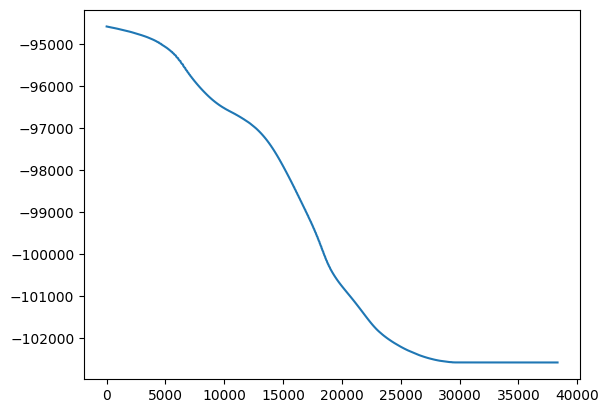

In [419]:
plt.plot(np.sum(np.sum(energies, axis = 1), axis = 1)/2)

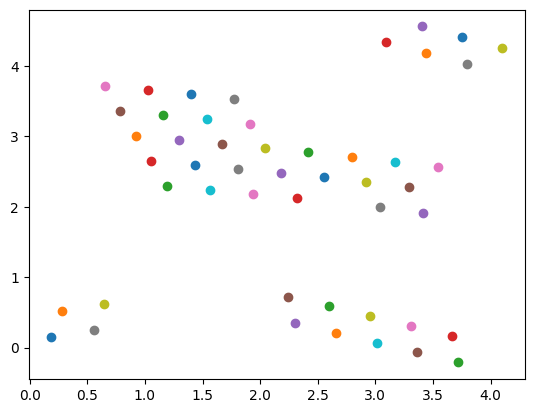

In [420]:
for i in range(box.n_particles):
    plt.scatter(box.particles_pos[i][0],box.particles_pos[i][1])

In [421]:
sim = Simulation(box,10000,2e-6)

In [422]:
sim.run()

/tmp/ipykernel_1095/1082760259.py:217: RuntimeWarning: divide by zero encountered in divide
  self.potEnergy_mat = np.where(self.distance_abs != 0, (self.c_12/(self.distance_abs**12)-self.c_6/(self.distance_abs**6)), 0) # shape: (n,n)
/tmp/ipykernel_1095/1082760259.py:217: RuntimeWarning: invalid value encountered in subtract
  self.potEnergy_mat = np.where(self.distance_abs != 0, (self.c_12/(self.distance_abs**12)-self.c_6/(self.distance_abs**6)), 0) # shape: (n,n)
/tmp/ipykernel_1095/1082760259.py:212: RuntimeWarning: divide by zero encountered in divide
  self.force_mat = np.where(distance_abs_newaxis != 0, (12*self.c_12/distance_abs_newaxis**14-6*self.c_6/distance_abs_newaxis**8)*self.distance_ghost, 0)
/tmp/ipykernel_1095/1082760259.py:212: RuntimeWarning: invalid value encountered in subtract
  self.force_mat = np.where(distance_abs_newaxis != 0, (12*self.c_12/distance_abs_newaxis**14-6*self.c_6/distance_abs_newaxis**8)*self.distance_ghost, 0)


In [423]:
anal = Analysis(sim)

In [439]:
np.sum(np.linalg.norm(anal.sim.data_traj[:,2,:,:], axis = 1)*anal.sim.box.particles_m[:,np.newaxis], axis = 0).shape

(10001,)

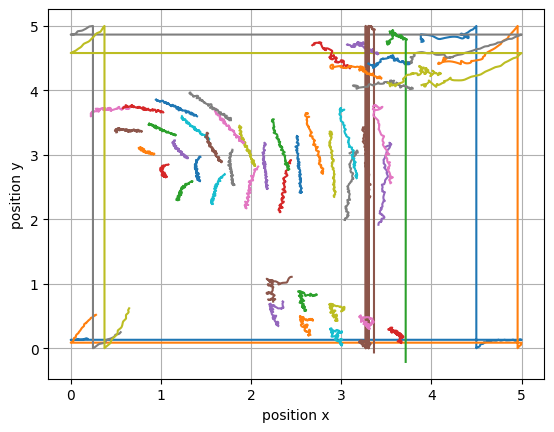

In [424]:
anal.show_traj()

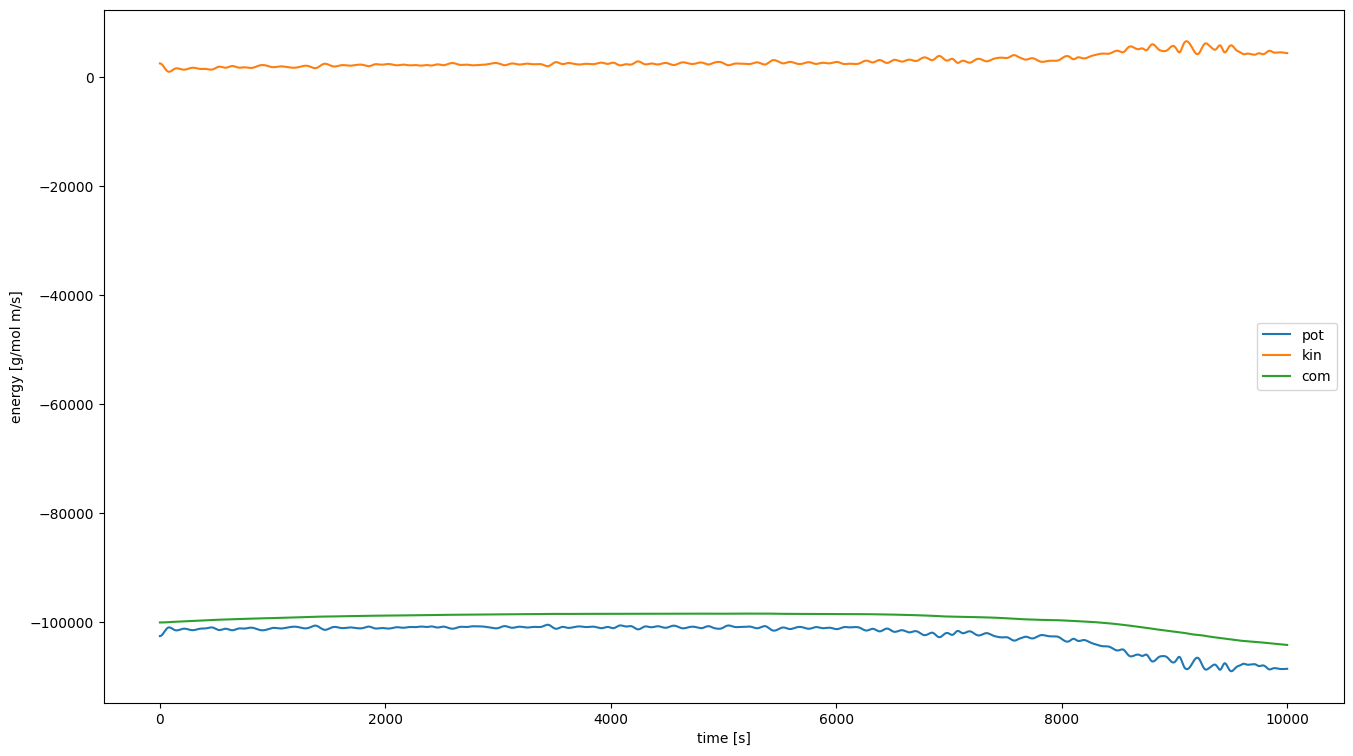

In [425]:
anal.plot_energies(kin = True, pot = True, com = True)

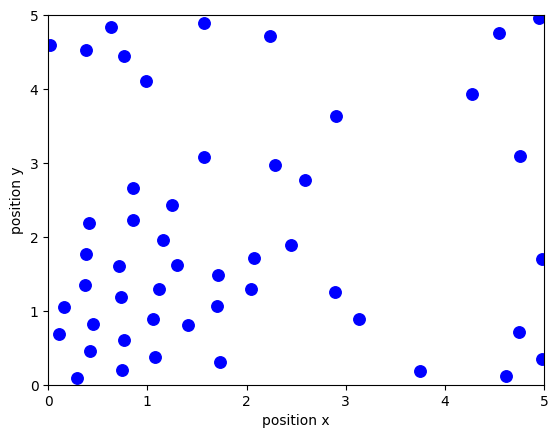

In [ ]:
# anal.animation(True)

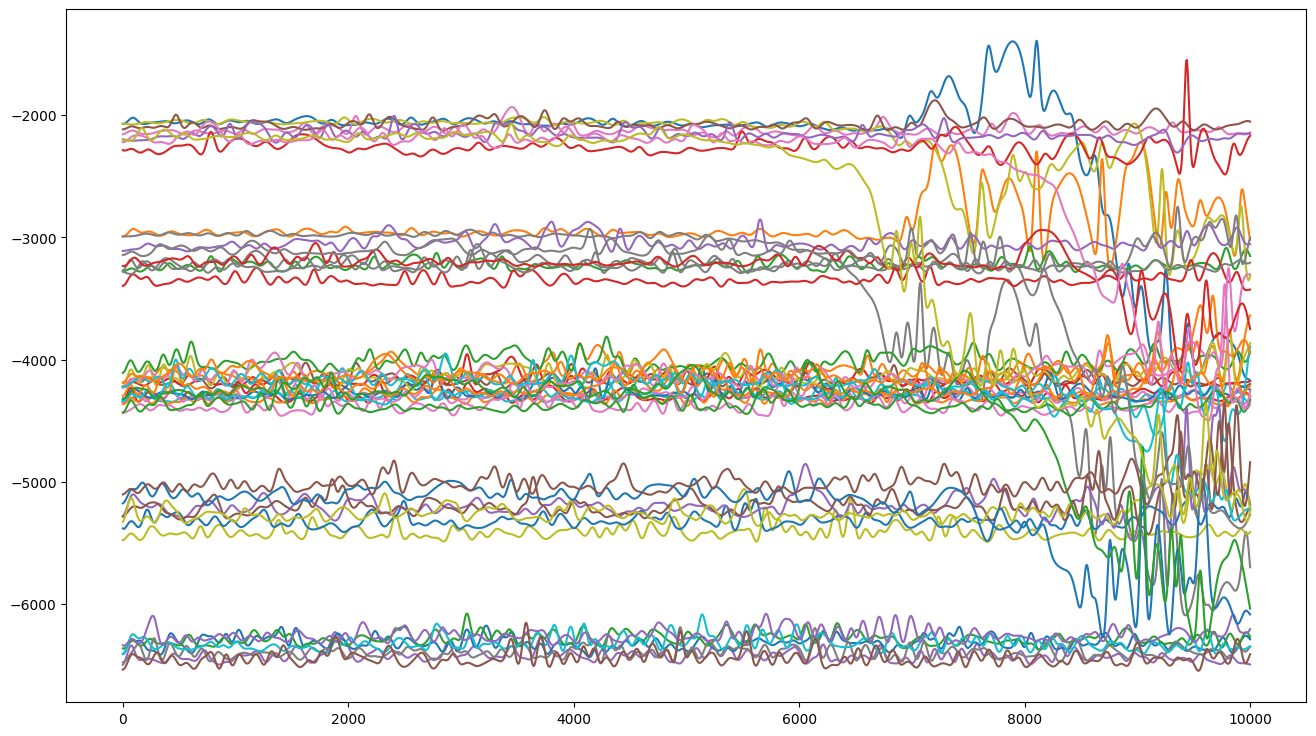

In [426]:
fig, ax = plt.subplots(figsize=(16, 9))
for i in range(anal.sim.box.n_particles):
    ax.plot(np.sum(anal.sim.pot_energy,axis=0)[i])

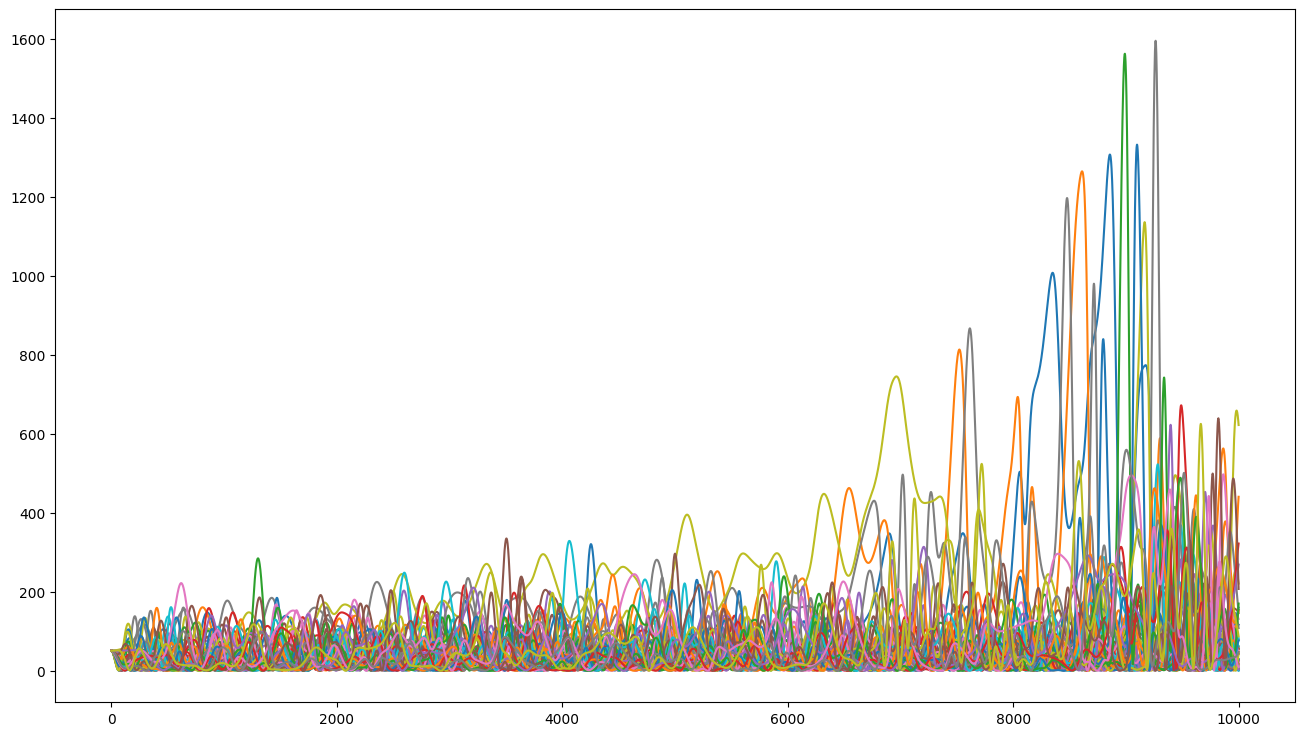

In [427]:
fig, ax = plt.subplots(figsize=(16, 9))
for i in range(anal.sim.box.n_particles):
    ax.plot(anal.sim.kin_energy[i])